# <span style="font-size: 30px;">EJERCICIO DE CLASIFICACIÓN BAYESIANA </span>

CONSIGNA: A partir del dataset de pesos y alturas, construir manualmente (sin usar sklearn) un Clasificador Bayesiano LDA. Para calcular los parámetros, utilizar las fórmulas compartidas en el notebook correspondiente.

## Librerias

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## <span style="font-size: 24px;">Preparación de los datos</span>

En esta sección se muestra la carga de datos de los archivos de entrenamiento y testeo. Además, cada conjunto de datos se subdivide a su vez en dos arrays: uno que contiene el género de los sujetos, y otro que contiene el peso y altura de cada muestra.

In [4]:
data_train=pd.read_csv('alturas-pesos-mils-train.csv')
data_test=pd.read_csv('alturas-pesos-mils-test.csv')

In [5]:
#Paso la infromación del .csv a vectores para que sea más fácil manipular la información
genero_train= data_train['Genero']
wh_train=data_train.iloc[:, 2:4].values

genero_test= data_test['Genero']
wh_test=data_test.iloc[:, 2:4].values

In [149]:
wh_train

array([[ 61.235, 162.402],
       [ 97.432, 181.908],
       [ 73.324, 172.459],
       ...,
       [ 75.461, 170.91 ],
       [ 65.461, 166.137],
       [ 80.323, 171.575]], shape=(8000, 2))

In [150]:
wh_test

array([[ 90.202, 177.68 ],
       [ 60.89 , 164.175],
       [ 67.629, 171.506],
       ...,
       [ 51.971, 154.277],
       [ 82.536, 172.26 ],
       [ 62.409, 166.244]], shape=(2000, 2))

In [6]:
data_hombre_test = data_test.loc[data_test['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres_test = data_test.loc[data_test['Genero']=='Mujer'][['Peso','Altura']].values
data_hombres_train = data_train.loc[data_train['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres_train = data_train.loc[data_train['Genero']=='Mujer'][['Peso','Altura']].values


# 1.Clasificador manual

Para comenzar, se realizó un clasificador que, dado el peso y la altura de una de las muestras, indique si es hombre o mujer. Para esto, se utilizó el teorema de Bayes según el cual:
\begin{equation}
  P(C_{i} | w, h) = \frac{P( w, h | C_{i})\times P(C_{i})}{P(w,h)}
\end{equation}

En donde 
\begin{equation}
    P(C_{i})
\end{equation}
es la información previa o **prior**, asociada a la probabilidad de que el sujeto sea hombre o mujer; 
\begin{equation}
    P( w, h | C_{i})
\end{equation}
es la **likelihood**, que indica la probabilidad de que el sujeto pese un determinado peso y mida una determinada altura, dado que es hombre o mujer; y
\begin{equation}
    P(w,h)
\end{equation}
es la probabilidad de que el sujeto tenga un peso y una altura determinados.

Como primer paso para alcanzar este objetivo, se calcularon las priors, dividiendo la cantidad de sujetos de un determinado género por la cantidad total de muestras. 

In [9]:
#Calculo las priors: la probabilidad de que una persona sea hombre o mujer
total=len(genero_train)
cant_hombres=len(genero_train[genero_train=='Hombre'])
cant_mujeres=len(genero_train[genero_train=='Mujer'])
suma=cant_mujeres + cant_hombres #esto es útil para asegurarse de que no hay otro tipo de dato
print("TOTAL:", total, "\nMUJERES",  cant_mujeres, "\nHOMBRES:", cant_hombres, "\nSUMA:", suma)
prior_hombre=cant_hombres/total
prior_mujer=cant_mujeres/total
print("PRIOR HOMBRES:", prior_hombre, "\nPRIOR MUJERES:", prior_mujer)

TOTAL: 8000 
MUJERES 3998 
HOMBRES: 4002 
SUMA: 8000
PRIOR HOMBRES: 0.50025 
PRIOR MUJERES: 0.49975


Dado que el peso y la altura son variable continuas, se discretizaron seprándolas en intervalos o bins. Para esto, primero visualizamos los datos en un gráfico para poder evaluar cuántos bins serían necesarios.

In [29]:
import seaborn as sns

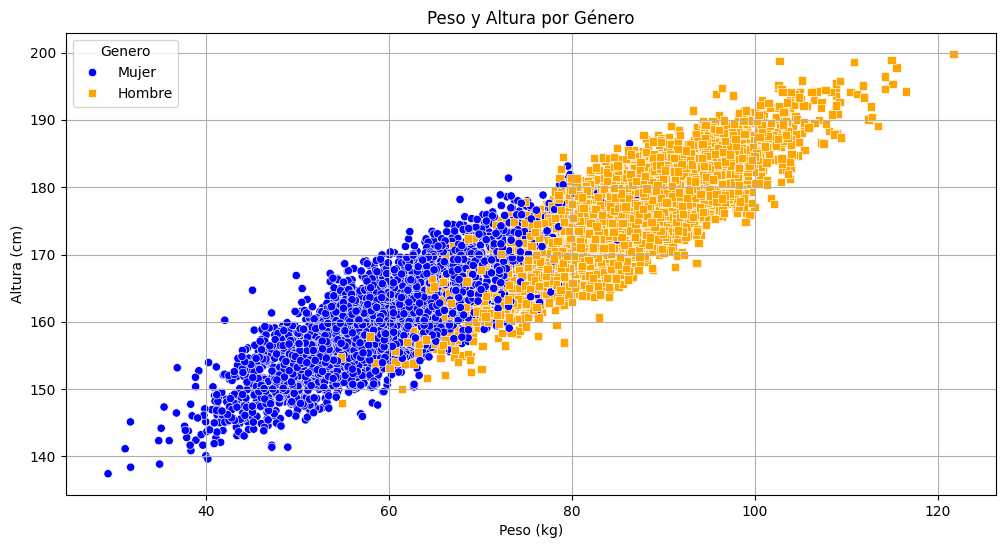

In [ ]:

data_combined = pd.concat([data_train, data_test])

plt.figure(figsize=(12, 6))
sns.scatterplot(data=data_combined, x='Peso', y='Altura', hue='Genero', style='Genero', markers=['o', 's'], palette=['blue', 'orange'])
plt.title('Peso y Altura por Género')
plt.xlabel('Peso (kg)')
plt.ylabel('Altura (cm)')
plt.grid(True)
plt.show()

Podemos observar que las alturas varían entre aproximadamente 135 cm y 205 cm, y los pesos entre 25 kg y 125 kg. Elegimos entonces dividir el espacio en 70 bines: de esta manera, en cada bin se encontrarán sujetos cuyas altura no difieran en más de 1cm y cuyos pesos no difieran en más de 1.43 kg.

Estos valores se eligieron arbitrariamente, de acuerdo al criterio  de los autores de este trabajo. Sin embargo, podría hacerse la prueba con una cantidad de bines diferente. Cuanto mayor sea el número de intervalos, menos muestras habrá en cada uno de ellos y menor será la diferencia entre los pesos y las alturas de los sujetos que contiene; y vice versa. Por lo tanto, a mayor número de bines, más probabilidad de sobre-ajustar el modelo, y a menor cantidad de bines mayor es la probabilidad de que la clasificación sea poco exacta.

Los cálculos se muestran en mayor detalle en el bloque de código a continuación. 

In [10]:
#Propiedades para los bines
minw=25
maxw=125
minh=135
maxh=205
cantidad_bines=70
ancho_bines_peso=(maxw-minw)/cantidad_bines
ancho_bines_altura=(maxh-minh)/cantidad_bines

print("Se divide la muestra en ", cantidad_bines, " bines")
print("En cada bin, la diferencia de alturas es de", ancho_bines_altura, "y la diferencia de pesos de ", round(ancho_bines_peso,2))

Se divide la muestra en  70  bines
En cada bin, la diferencia de alturas es de 1.0 y la diferencia de pesos de  1.43


Una vez realizado esto, se observó que muchas de las muestras pertenecientes al conjunto de testeo pertenecen a bines en donde no hay ninguna muestra del conjunto de entrenamiento (concretamente, hay 49 datos con este problema). Para solucionar este problema, se diseñaron dos posibles algoritmos de clasificación. A continuación se muestra el código y los resultados para ambos casos.  

## OPCIÓN A:

Este primer clasificador identifca las muestras que no pueden ser etiquetadas debido a que no existen datos de entrenamiento en el mismo bin, y las descarta. 



In [12]:
#OPCIÓN 1 - Si llega a un dato que no se puede clasificar, no lo toma en consideración
def probabilidad_wh_A(wh_vector, genero):
  cont_wh=0
  cont_dado_genero=0
  if(genero=='Hombre'):
    cant_genero=cant_hombres
  else:
    cant_genero=cant_mujeres

  peso=wh_vector[0]
  altura=wh_vector[1]

  #identifico en qué bin está
  binW=int((peso-minw)/ancho_bines_peso)
  binH=int((altura-minh)/ancho_bines_altura)

  infW=minw+binW*ancho_bines_peso #límite inferior de peso del bin
  supW=minw+(binW+1)*ancho_bines_peso #límite superior de peso del bin
  infH=minh+binH*ancho_bines_altura #límite inferior de altura del bin
  supH=minh+(binH+1)*ancho_bines_altura #límite superior de altura del bin

  #cuento cuántas muestras hay en ese bin
  for i in range(total):
    if (infW<= wh_train[i, 0] <supW) and (infH<= wh_train[i,1] <supH):
      cont_wh+=1
      if (genero_train[i]==genero):
        cont_dado_genero+=1

  if cont_wh==0:
    clasificado=False
    proba=0
    likelihood=0
  else:
      clasificado=True
      proba=cont_wh/total
      likelihood=cont_dado_genero/cant_genero
  
  return proba, likelihood, clasificado

In [13]:
def clasificador_manual_A(wh_vector, genero_vector):
    cant_noClasificados=0
    prediccion=[] #en este vector guardo los resultados de la predicción
    genero_real=[] #aquí se genera una lista del género real del sujeto, quitando los de las muestras que tuvieron que ser descartadas

    #Recorre todos los elementos del array y los clasifica 
    for i in range(len(genero_vector)):
        #print("Evalúo el elemento ",i, "---PESO=", peso_train[i], "---ALTURA=", altura_train[i])
        proba_wh, likelihood_hombre,clasificado= probabilidad_wh_A(wh_vector[i], 'Hombre')

        if clasificado==True:
            genero_real.append(genero_vector[i]) #si se pudo clasificar, adjunto su género a la lista de los valores reales. 
            #Calculo, por medio del teorema de Bayes, la probabilidad de que sea hombre
            hombre_dado_wh= (likelihood_hombre * prior_hombre)/proba_wh
            if(hombre_dado_wh>0.5):
                prediccion.append(1) #de esta forma, HOMBRE=1 MUJER=0
            else:
                prediccion.append(0)
        if clasificado==False:
            cant_noClasificados+=1
            print("La muestra ", i, "no se pudo clasificar")
    
    print("\n\nHUBO ", cant_noClasificados, " ELEMENTOS QUE NO PUDIERON SER CLASIFICADOS")
    #una vez que termina, convierto la lista con las predicciones en array
    prediccion=np.array(prediccion)

    return prediccion, genero_real

A continuación, pueden apreciarse los resultados de este algoritmo.

Cuando se aplica la función sobre el conjunto de entrtenamiento, se ve que todas las muestras pueden ser clasificadas, lo cual es trivial, pero al aplicarla sobre el conjunto de entrenamiento se enlistan las muestras que no pudieron ser clasificadas y se encuentra que hubo 49 muestras con este problema. 

In [14]:
#con la primera opción
prediccion_manual_train_A, _=clasificador_manual_A(wh_train, genero_train)



HUBO  0  ELEMENTOS QUE NO PUDIERON SER CLASIFICADOS


In [15]:
prediccion_manual_test_A, genero_test_acotado=clasificador_manual_A(wh_test, genero_test)

La muestra  49 no se pudo clasificar
La muestra  123 no se pudo clasificar
La muestra  192 no se pudo clasificar
La muestra  256 no se pudo clasificar
La muestra  259 no se pudo clasificar
La muestra  369 no se pudo clasificar
La muestra  372 no se pudo clasificar
La muestra  374 no se pudo clasificar
La muestra  376 no se pudo clasificar
La muestra  383 no se pudo clasificar
La muestra  526 no se pudo clasificar
La muestra  534 no se pudo clasificar
La muestra  564 no se pudo clasificar
La muestra  570 no se pudo clasificar
La muestra  626 no se pudo clasificar
La muestra  635 no se pudo clasificar
La muestra  710 no se pudo clasificar
La muestra  730 no se pudo clasificar
La muestra  746 no se pudo clasificar
La muestra  773 no se pudo clasificar
La muestra  792 no se pudo clasificar
La muestra  796 no se pudo clasificar
La muestra  925 no se pudo clasificar
La muestra  981 no se pudo clasificar
La muestra  985 no se pudo clasificar
La muestra  1040 no se pudo clasificar
La muestra  

## OPCIÓN B:

En este segundo clasificador, si hay un dato que no puede ser clasificado, se compara esa muestra con los bins de alrededor del bin que le corresponde. Si aún con los bines vecinos no se puede hacer la clasificación, se ampliará el área de comparación hasta que la muestra pueda ser clasificada.

In [16]:
def probabilidad_wh_B(wh_vector, genero, indice):
  cont_wh=0
  k=-1
  cont_dado_genero=0
  if(genero=='Hombre'):
    cant_genero=cant_hombres
  else:
    cant_genero=cant_mujeres

  peso=wh_vector[0]
  altura=wh_vector[1]
  #identifico en qué bin está
  binW=int((peso-minw)/ancho_bines_peso)
  binH=int((altura-minh)/ancho_bines_altura)

  while(cont_wh==0): #Si encontró al menos un elemento en el mismo bin, sigue. Sino, se aplía el bin y se vuelve a hacer la búsqueda.
    k+=1
    infW=minw+(binW-k)*ancho_bines_peso #límite inferior de peso del bin
    supW=minw+(binW+1+k)*ancho_bines_peso #límite superior de peso del bin
    infH=minh+(binH-k)*ancho_bines_altura #límite inferior de altura del bin
    supH=minh+(binH+1+k)*ancho_bines_altura #límite superior de altura del bin

    #cuento cuántas muestras hay en ese bin
    for i in range(total):
      if (infW<= wh_train[i, 0] <supW) and (infH<= wh_train[i,1] <supH):
        cont_wh+=1
        if (genero_train[i]==genero):
          cont_dado_genero+=1
  
  if k!=0:
    print("Para la muestra ", indice, "Se amplió ", k, "veces el espacio de comparación")

  proba=cont_wh/total
  likelihood=cont_dado_genero/cant_genero

  return proba, likelihood

In [17]:
def clasificador_manual_B(wh_vector, genero_vector):
    prediccion=np.zeros(len(genero_vector)) #en este vector guardo los resultados de la predicción

    #Recorre todos los elementos del array y los clasifica 
    for i in range(len(genero_vector)):
        #print("Evalúo el elemento ",i, "---PESO=", peso_train[i], "---ALTURA=", altura_train[i])
        proba_wh, likelihood_hombre= probabilidad_wh_B(wh_vector[i], 'Hombre', i)
        hombre_dado_wh= (likelihood_hombre * prior_hombre)/proba_wh
        if(hombre_dado_wh>0.5):
            prediccion[i]=1 

    return prediccion

Veamos entonces los resultados para este clasificador

Nuevamente, las muestras del conjunto de entrenamiento se clasifican satisfactoriamente, y en el caso de los datos de testeo se logra hacer la clasificación comparándolos con muestras más alejadas en los casos en los que es necesario.  

In [18]:
prediccion_manual_train_B=clasificador_manual_B(wh_train, genero_train)

In [19]:
prediccion_manual_test_B=clasificador_manual_B(wh_test, genero_test)

Para la muestra  49 Se amplió  1 veces el espacio de comparación
Para la muestra  123 Se amplió  3 veces el espacio de comparación
Para la muestra  192 Se amplió  1 veces el espacio de comparación
Para la muestra  256 Se amplió  1 veces el espacio de comparación
Para la muestra  259 Se amplió  1 veces el espacio de comparación
Para la muestra  369 Se amplió  1 veces el espacio de comparación
Para la muestra  372 Se amplió  1 veces el espacio de comparación
Para la muestra  374 Se amplió  1 veces el espacio de comparación
Para la muestra  376 Se amplió  1 veces el espacio de comparación
Para la muestra  383 Se amplió  1 veces el espacio de comparación
Para la muestra  526 Se amplió  1 veces el espacio de comparación
Para la muestra  534 Se amplió  3 veces el espacio de comparación
Para la muestra  564 Se amplió  1 veces el espacio de comparación
Para la muestra  570 Se amplió  1 veces el espacio de comparación
Para la muestra  626 Se amplió  1 veces el espacio de comparación
Para la mue

## Métricas

Para evaluar los modelos bayesianos, primero convertimos los nombres 'Hombre' y 'Mujer' de los arrays con las etiquetas reales en valores binarios: 0 y 1.

In [7]:
def binarizar_genero(vector):
    binarizado=np.zeros(len(vector))
    for i in range(len(vector)):
        if (vector[i]=='Hombre'):
            binarizado[i]=1
    return binarizado

In [20]:
#Paso los valores reales a números
genero_train_binario=binarizar_genero(genero_train)
genero_test_binario=binarizar_genero(genero_test)
genero_test_acotado_binario = binarizar_genero(genero_test_acotado)

In [21]:
etiquetas=['Hombre', 'Mujer']

Luego se diseñó una función para calcular el accuracy, según la ecuación: 

\begin{equation}
 \frac{TP +TN}{TP + TN + FP + FN}
\end{equation}

es decir, el cociente entre número total de positivos y la cantidad total de muestras. 

In [28]:
def accuracy_manual(prediccion, vector_real):
    TP=0 #que prediga que es hombre (1) y realmente lo sea
    TN=0 #que prediga que es mujer (0) y realmente lo sea 
    for i in range(len(vector_real)):
        if (prediccion[i]==1 and vector_real[i]==1):
            TP+=1
        if (prediccion[i]==0 and vector_real[i]==0):
            TN+=1
    accuracy=(TP + TN)/(len(vector_real))
    return accuracy 

In [30]:
accuracy_manual_A_train = accuracy_manual(prediccion_manual_train_A, genero_train_binario)
accuracy_manual_A_test = accuracy_manual(prediccion_manual_test_A, genero_test_acotado_binario)

accuracy_manual_B_train=accuracy_manual(prediccion_manual_train_B, genero_train_binario)
accuracy_manual_B_test=accuracy_manual(prediccion_manual_test_B, genero_test_binario)

print("ACCURACY DE LOS MODELOS HECHOS MANUALMENTE")
print("MODELO A (opción 1)")
print("\tConjunto de entrenamiento: ", round(accuracy_manual_A_train, 3), "\n\tConjunto de testeo: ", round(accuracy_manual_A_test, 3))

print("MODELO B (opción 2)")
print("\tConjunto de entrenamiento: ", round(accuracy_manual_B_train, 3), "\n\tConjunto de testeo: ", round(accuracy_manual_B_test, 3))

ACCURACY DE LOS MODELOS HECHOS MANUALMENTE
MODELO A (opción 1)
	Conjunto de entrenamiento:  0.922 
	Conjunto de testeo:  0.912
MODELO B (opción 2)
	Conjunto de entrenamiento:  0.922 
	Conjunto de testeo:  0.913


Entonces, podemos ver que la exactitud o **accuracy** del modelo bayesiano construido manualmente es de 0.922. Esto se cumple para ambas variantes del modelo, ya que no cambia el mecanismo de clasificación para estos casos. Por otro lado, para los conjuntos de testeo el accuracy es similar en ambos casos, siendo de 0.913 para la variable A y 0.913 para la variable B. El hecho de que en el segundo modelo la precisión sea mayor puede deberse a que hay más muestras, y dentro de ellas hay mayor cantidad de predicciones acertadas que erradas. 


Finalmente, para mostrar de una manera más gráfica os resultados, se utilizó la librería sklearnmetrics para generar una matriz de confusión.

In [ ]:
from sklearn.metrics import confusion_matrix

In [32]:
cm_manual_A_train=confusion_matrix(genero_train_binario, prediccion_manual_train_A)
cm_manual_A_test=confusion_matrix(genero_test_acotado_binario, prediccion_manual_test_A)

cm_manual_B_train=confusion_matrix(genero_train_binario, prediccion_manual_train_B)
cm_manual_B_test=confusion_matrix(genero_test_binario, prediccion_manual_test_B)

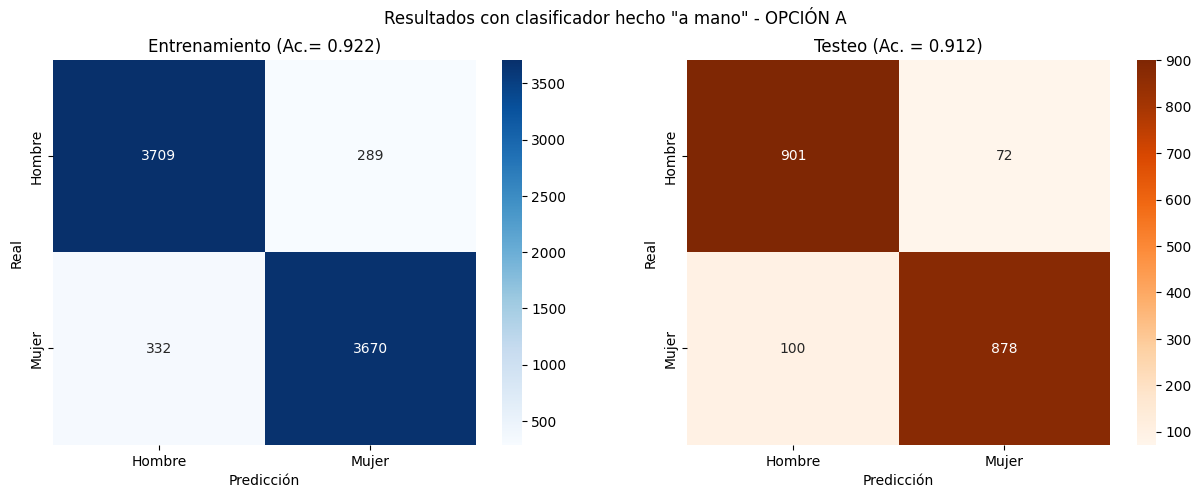

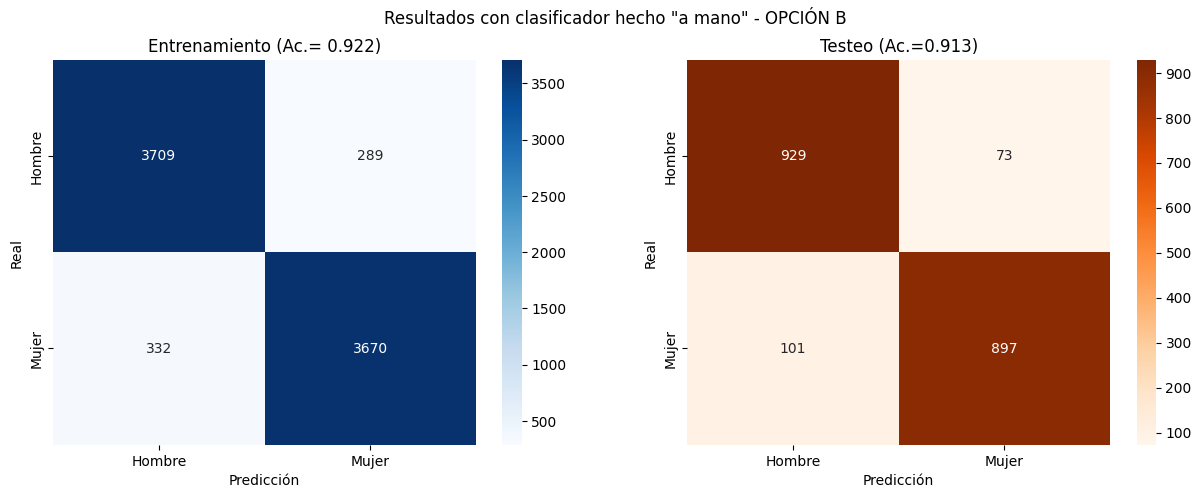

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Resultados con clasificador hecho "a mano" - OPCIÓN A')

sns.heatmap(cm_manual_A_train, annot=True, fmt="d", cmap="Blues", ax=ax[0],  xticklabels= etiquetas, yticklabels= etiquetas)
ax[0].set_title("Entrenamiento (Ac.= 0.922)")
ax[0].set_xlabel("Predicción")
ax[0].set_ylabel("Real")

sns.heatmap(cm_manual_A_test, annot=True, fmt="d", cmap="Oranges", ax=ax[1], xticklabels= etiquetas, yticklabels= etiquetas)
ax[1].set_title("Testeo (Ac. = 0.912)")
ax[1].set_xlabel("Predicción")
ax[1].set_ylabel("Real")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Resultados con clasificador hecho "a mano" - OPCIÓN B')

sns.heatmap(cm_manual_B_train, annot=True, fmt="d", cmap="Blues", ax=ax[0],  xticklabels= etiquetas, yticklabels= etiquetas)
ax[0].set_title("Entrenamiento (Ac.= 0.922)")
ax[0].set_xlabel("Predicción")
ax[0].set_ylabel("Real")

sns.heatmap(cm_manual_B_test, annot=True, fmt="d", cmap="Oranges", ax=ax[1], xticklabels= etiquetas, yticklabels= etiquetas)
ax[1].set_title("Testeo (Ac.=0.913)")
ax[1].set_xlabel("Predicción")
ax[1].set_ylabel("Real")
plt.show()

Con la matriz de confusión se puede corroborar que para el modelo B hay mayor cantidad de muestras en el conjunto de testeo, y que estas fueron, en su mayoría, clasificadas correctamente. De hecho, se incorporaron 28 muestras que se clasificaron correctamente como hombres, 12 que se clasificaron acertadamente como mujeres y sólo 2 que fueron mal clasificadas. 

In [187]:
def clasificador_manual_A_2(wh_vector, genero_vector):
    cant_noClasificados=0
    prediccion=[] #en este vector guardo los resultados de la predicción
    probs = []
    #Recorre todos los elementos del array y los clasifica 
    for i in range(len(genero_vector)):
        #print("Evalúo el elemento ",i, "---PESO=", peso_train[i], "---ALTURA=", altura_train[i])
        proba_wh, likelihood_hombre,clasificado= probabilidad_wh_A(wh_vector[i], 'Hombre')

        if clasificado==True:
            #Calculo, por medio del teorema de Bayes, la probabilidad de que sea hombre
            hombre_dado_wh= (likelihood_hombre * prior_hombre)/proba_wh
            probs.append(hombre_dado_wh)
            if(hombre_dado_wh>0.5):
                prediccion.append(1) #de esta forma, HOMBRE=1 MUJER=0
            else:
                prediccion.append(0)
        if clasificado==False:
            cant_noClasificados+=1
            print("La muestra ", i, "no se pudo clasificar")
    
    print("\n\nHUBO ", cant_noClasificados, " ELEMENTOS QUE NO PUDIERON SER CLASIFICADOS")
    #una vez que termina, convierto la lista con las predicciones en array
    prediccion=np.array(prediccion)

    return prediccion, probs

In [ ]:
p = clasificador_manual_A_2(wh_train, genero_train)


# 2.  Clasificador de Scikit-Learn

Luego de diseñar los clasificadores bayesianos, se entrenó un claisficador bayesiano de la librería Scikit-Learn (Sklearn). De entre las diferentes posibilidades que ofrece Sklearn  para realizar una clasificación bayesiana, se seleccionó el modelo GaussianNB, o *Gaussian Naive Bayes*. Este modelo asume que las características de los datos son independientes entre sí, y que presentan una dsitribución gausiana, es decir: 
\begin{equation}
    P(x_{i} | C )= \frac{1}{\sqrt{2\pi\sigma^{2}_{c}}}\times exp({ - \frac{({x_{i} - \mu_{i}})^{2}}{2\sigma^{2}_{c}}})
\end{equation}

In [1]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [22]:
clf_gauss = GaussianNB()
clf_gauss.fit(wh_train, genero_train_binario)  

clf_multi = MultinomialNB()
clf_multi.fit(wh_train, genero_train_binario)

MultinomialNB()

In [23]:
prediccion_gauss_train = clf_gauss.predict(wh_train)
prediccion_gauss_test = clf_gauss.predict(wh_test)

In [24]:
prediccion_multinomial_train = clf_multi.predict(wh_train)
prediccion_multinomial_test = clf_multi.predict(wh_test)

## Métricas

Luego, se usaron las funciones propias de Sklearn para calcular el accuracy en los conjuntos de entrenamiento y testeo, y nuevamente sse construyeron las matrices de confusión para evaluar los resultados.

In [25]:
from sklearn.metrics import accuracy_score
accuracy_gauss_train = accuracy_score(genero_train_binario, prediccion_gauss_train )
accuracy_gauss_test = accuracy_score(genero_test_binario, prediccion_gauss_test)

accuracy_multinomial_train = accuracy_score(genero_train_binario, prediccion_multinomial_train )
accuracy_multinomial_test = accuracy_score(genero_test_binario, prediccion_multinomial_test)

In [27]:
print("ACCURACY DE LOS MODELOS ENTRENADOS CON SCIKIT-LEARN")
print("MODELO CON CARACTERÍSTICAS DE DISTRIBUCIÓN GAUSSIANA")
print("\tConjunto de entrenamiento: ", accuracy_gauss_train, "\n\tConjunto de testeo: ", accuracy_gauss_test)
print("MODELO CON CARACTERÍSTICAS DE DISTRIBUCIÓN MULTINOMIAL")
print("\tConjunto de entrenamiento: ", accuracy_multinomial_train, "\n\tConjunto de testeo: ", accuracy_multinomial_test)

ACCURACY DE LOS MODELOS ENTRENADOS CON SCIKIT-LEARN
MODELO CON CARACTERÍSTICAS DE DISTRIBUCIÓN GAUSSIANA
	Conjunto de entrenamiento:  0.887 
	Conjunto de testeo:  0.887
MODELO CON CARACTERÍSTICAS DE DISTRIBUCIÓN MULTINOMIAL
	Conjunto de entrenamiento:  0.91325 
	Conjunto de testeo:  0.9185


Para dar una mayor idea sobre el desempeño del modelo, mostramos las matrices de confusión.

In [33]:
cm_gauss_train=confusion_matrix(genero_train_binario, prediccion_gauss_train)
cm_gauss_test=confusion_matrix(genero_test_binario, prediccion_gauss_test)

cm_multinomial_train=confusion_matrix(genero_train_binario, prediccion_multinomial_train)
cm_multinomial_test=confusion_matrix(genero_test_binario, prediccion_multinomial_test)

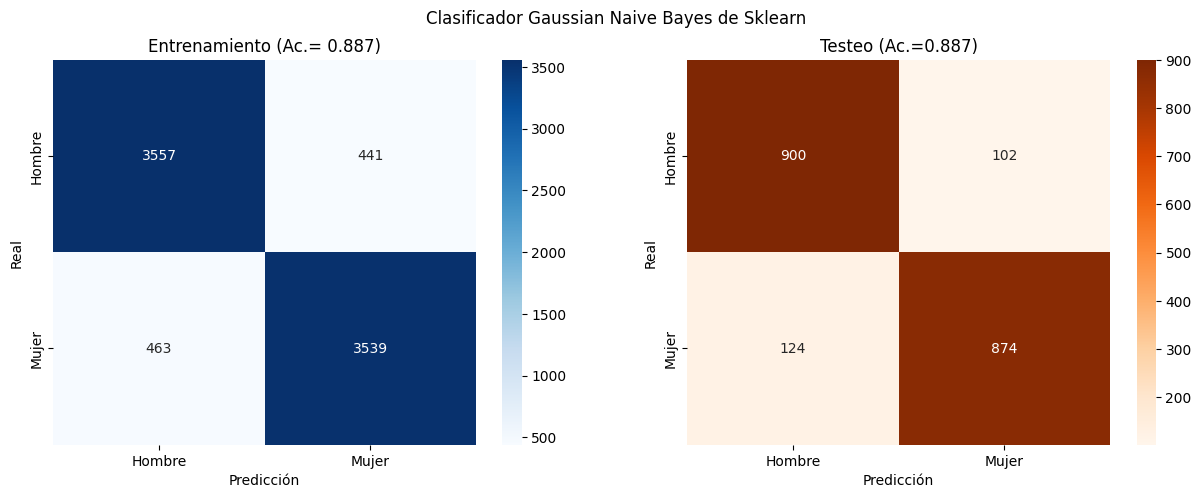

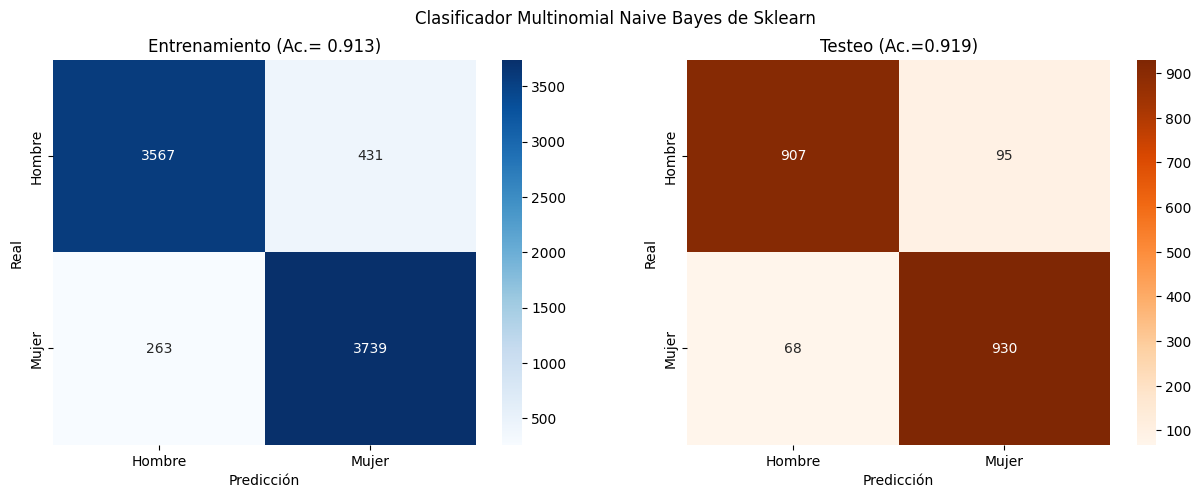

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Clasificador Gaussian Naive Bayes de Sklearn')
sns.heatmap(cm_gauss_train, annot=True, fmt="d", cmap="Blues", ax=ax[0],  xticklabels= etiquetas, yticklabels= etiquetas)
ax[0].set_title("Entrenamiento (Ac.= 0.887)")
ax[0].set_xlabel("Predicción")
ax[0].set_ylabel("Real")
sns.heatmap(cm_gauss_test, annot=True, fmt="d", cmap="Oranges", ax=ax[1], xticklabels= etiquetas, yticklabels= etiquetas)
ax[1].set_title("Testeo (Ac.=0.887)")
ax[1].set_xlabel("Predicción")
ax[1].set_ylabel("Real")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Clasificador Multinomial Naive Bayes de Sklearn')
sns.heatmap(cm_multinomial_train, annot=True, fmt="d", cmap="Blues", ax=ax[0],  xticklabels= etiquetas, yticklabels= etiquetas)
ax[0].set_title("Entrenamiento (Ac.= 0.913)")
ax[0].set_xlabel("Predicción")
ax[0].set_ylabel("Real")
sns.heatmap(cm_multinomial_test, annot=True, fmt="d", cmap="Oranges", ax=ax[1], xticklabels= etiquetas, yticklabels= etiquetas)
ax[1].set_title("Testeo (Ac.=0.919)")
ax[1].set_xlabel("Predicción")
ax[1].set_ylabel("Real")
plt.show()

Si comparamos el accuracy de este modelo con el de la sección anterior, es sorprendente observar que el clasificador manual resulta en una clasificación más precisa que el clasificador de Scikit-Learn, ya que en el primero el accuracy es de 0.922 para el conjunto de entrenamiento y aproximadamente 0.91 para el de testeo, mientras que en el segundo el accuracy es de 0.877 tanto para entrenamiento como para testo.
 

Esta diferencia puede deberse a que en el modelo de Sklearn se asume la independencia condicional de las muestras, es decir, que los valores del peso y altura de un sujeto de un género determinado son independientes entre sí. En realidad, sabemos que suele existir una correlación positiva entre el peso y la altura de una persona, y que además ambos valores tienden a ser mayores cuando se trata de un hombre. 

Por otro lado, en el clasificador Bayesiano diseñado por nosotros no se asume nada sobre la distribución de las muestras, sino que cada una se clasifica de acuerdo con la etiqueta de los datos similares.

# 3. Método de Expansión Cuadrática </span>

Posteriormente, se realizó una expansión cuadrática de los datos y se volvió a entrenar el modelo bayesiano de la librería Scikit-Learn. Para la expansión cuadrática, se diseñó una función que generar nuevos arrays para los conjuntos de entrenamiento y testeo, que no solamente contuvieran los datos de peso ($w$) y altura ($h$), sino también $w^{2}$, $h^{2}$ y $w\times h$.

In [35]:
def expandir_datos(wh_vector):
    datos_extension=np.zeros([len(wh_vector), 5])
    for i in range(len(wh_vector)):
        peso=wh_train[i, 0]
        altura=wh_train[i, 1]
        datos_extension[i, 0]=peso
        datos_extension[i, 1]=peso**2
        datos_extension[i, 2]=altura
        datos_extension[i, 3]=altura**2
        datos_extension[i, 4]=peso*altura
    return datos_extension

In [36]:
datos_expansion_train= expandir_datos(wh_train)
datos_expansion_test=expandir_datos(wh_test)

In [37]:
#Entrenamos el modelo
clf_expansion_gauss = GaussianNB()
clf_expansion_gauss.fit(datos_expansion_train, genero_train_binario)  

clf_expansion_multinomial = MultinomialNB()
clf_expansion_multinomial.fit(datos_expansion_train, genero_train_binario)  

MultinomialNB()

In [38]:
prediccion_expansion_gauss_train = clf_expansion_gauss.predict(datos_expansion_train)
prediccion_expansion_gauss_test = clf_expansion_gauss.predict(datos_expansion_test)

prediccion_expansion_multinomial_train = clf_expansion_multinomial.predict(datos_expansion_train)
prediccion_expansion_multinomial_test = clf_expansion_multinomial.predict(datos_expansion_test)

## Métricas

Como en los casos anteriores, se calculó el accuracy del clasificador y se visualizaron los resultados en una matriz de confusión. 

In [40]:
accuracy_expansion_gauss_train = accuracy_score(genero_train_binario, prediccion_expansion_gauss_train )
accuracy_expansion_gauss_test = accuracy_score(genero_test_binario, prediccion_expansion_gauss_test)
accuracy_expansion_multinomial_train = accuracy_score(genero_train_binario, prediccion_expansion_multinomial_train )
accuracy_expansion_multinomial_test = accuracy_score(genero_test_binario, prediccion_expansion_multinomial_test)


In [41]:
print("ACCURACY DE LOS MODELOS ENTRENADOS CON SCIKIT-LEARN, TRAS HACER UNA EXPANSIÓN CUADRÁTICA DE LOS DATOS")
print("MODELO CON CARACTERÍSTICAS DE DISTRIBUCIÓN GAUSSIANA")
print("\tConjunto de entrenamiento: ", accuracy_expansion_gauss_train, "\n\tConjunto de testeo: ", accuracy_expansion_gauss_test)
print("MODELO CON CARACTERÍSTICAS DE DISTRIBUCIÓN MULTINOMIAL")
print("\tConjunto de entrenamiento: ", accuracy_expansion_multinomial_train, "\n\tConjunto de testeo: ", accuracy_expansion_multinomial_test)

ACCURACY DE LOS MODELOS ENTRENADOS CON SCIKIT-LEARN, TRAS HACER UNA EXPANSIÓN CUADRÁTICA DE LOS DATOS
MODELO CON CARACTERÍSTICAS DE DISTRIBUCIÓN GAUSSIANA
	Conjunto de entrenamiento:  0.890375 
	Conjunto de testeo:  0.495
MODELO CON CARACTERÍSTICAS DE DISTRIBUCIÓN MULTINOMIAL
	Conjunto de entrenamiento:  0.914625 
	Conjunto de testeo:  0.483


In [42]:
cm_expansion_gauss_train=confusion_matrix(genero_train_binario, prediccion_expansion_gauss_train)
cm_expansion_gauss_test=confusion_matrix(genero_test_binario, prediccion_expansion_gauss_test)

cm_expansion_multinomial_train=confusion_matrix(genero_train_binario, prediccion_expansion_multinomial_train)
cm_expansion_multinomial_test=confusion_matrix(genero_test_binario, prediccion_expansion_multinomial_test)

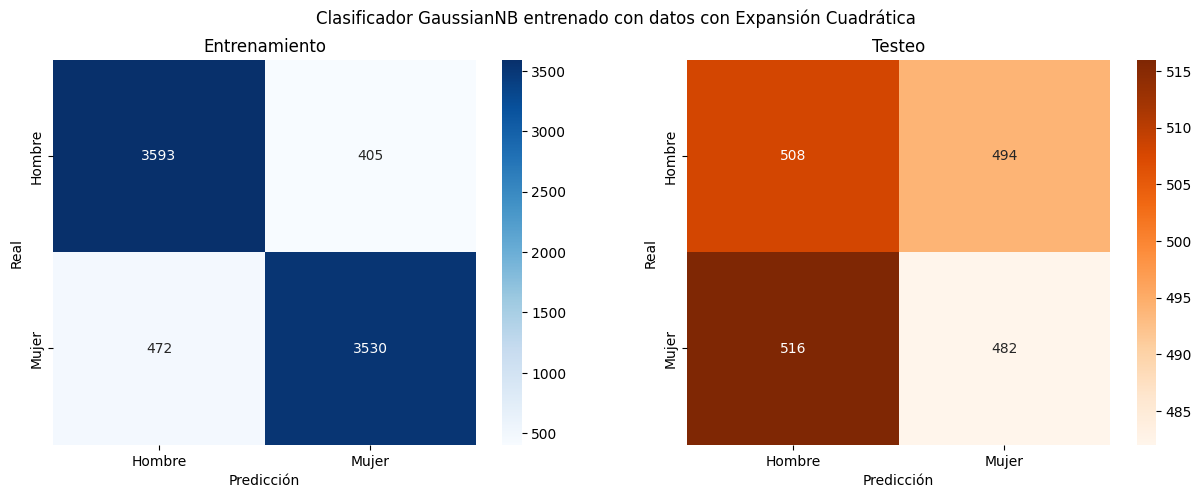

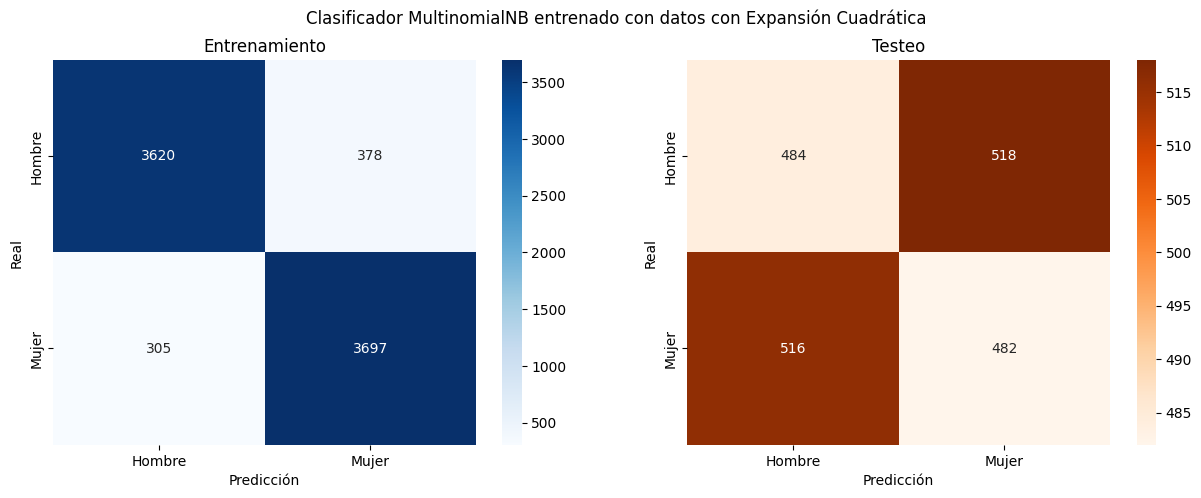

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Clasificador GaussianNB entrenado con datos con Expansión Cuadrática')
sns.heatmap(cm_expansion_gauss_train, annot=True, fmt="d", cmap="Blues", ax=ax[0],  xticklabels= etiquetas, yticklabels= etiquetas)
ax[0].set_title("Entrenamiento")
ax[0].set_xlabel("Predicción")
ax[0].set_ylabel("Real")
sns.heatmap(cm_expansion_gauss_test, annot=True, fmt="d", cmap="Oranges", ax=ax[1], xticklabels= etiquetas, yticklabels= etiquetas)
ax[1].set_title("Testeo")
ax[1].set_xlabel("Predicción")
ax[1].set_ylabel("Real")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Clasificador MultinomialNB entrenado con datos con Expansión Cuadrática')
sns.heatmap(cm_expansion_multinomial_train, annot=True, fmt="d", cmap="Blues", ax=ax[0],  xticklabels= etiquetas, yticklabels= etiquetas)
ax[0].set_title("Entrenamiento")
ax[0].set_xlabel("Predicción")
ax[0].set_ylabel("Real")
sns.heatmap(cm_expansion_multinomial_test, annot=True, fmt="d", cmap="Oranges", ax=ax[1], xticklabels= etiquetas, yticklabels= etiquetas)
ax[1].set_title("Testeo")
ax[1].set_xlabel("Predicción")
ax[1].set_ylabel("Real")
plt.show()

Podemos observar que el accuracy para el conjunto de entrenamiento fue de 0.89, lo cual es mayor que para el clasificador Bayesiano de Scikit learn entrenado con los datos originales, pero aún menor que el accuracy del clasificador diseñado manualmente. Por otro lado, es sorprendente encontrar que para el conjunto de testeo el accuracy fue de 0.495, lo cual es considerablemente menor al de los otros dos modelos, y que es menor a la probabilidad de que una sujeto pertenezca a una clase en particular (siendo 0.50025 la probabilidad de que sea hombre y 0.49975 de que sea mujer). 

La expansión cuadrática tiene como ventaja la generación de nuevos datos, lo cual implica una mayor cantidad de información a tener en cuenta a la hora de realizar la clasificación. En este caso, un modelo que antes tenía sólo dos parámetros ahora tiene cinco. 

Pensamos que el decremento en el desempeño del modelo entrenado con estos datos puede estar relacionado a qué tan representativos son los mismos del problema que se busca solucionar. 

# 4. Regresión Logística

Finalmente, entrenamos un modelo de regresión logística.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [48]:
log_Reg = LogisticRegression(C=1e12)
log_Reg.fit(wh_train, genero_train)

LogisticRegression(C=1000000000000.0)

# 5. Visualización de los umbrales

En esta sección mostramos de forma gráfica los umbrales de decisión de cada uno de los modelos propuestos.

In [266]:
x_min, x_max = wh_train[:, 0].min() - 1, wh_train[:, 0].max() + 1
y_min, y_max = wh_train[:, 1].min() - 1, wh_train[:, 1].max() + 1

# Crear la malla
# Tamaño del paso de la malla
xx, yy = np.meshgrid(np.arange(x_min, x_max, ancho_bines_altura),
                     np.arange(y_min, y_max, ancho_bines_peso))

def clasificar_malla_A(xx, yy):
    """Clasifica cada punto de la malla usando el clasificador bayesiano propio."""
    puntos = np.c_[xx.ravel(), yy.ravel()]
    clases = []
    
    for punto in puntos:
        proba_wh, likelihood_hombre, clasificado = probabilidad_wh_A(punto, 'Hombre')
        if clasificado:
            hombre_dado_wh = (likelihood_hombre * prior_hombre) / proba_wh
            clases.append(hombre_dado_wh)
        else:
            # En lugar de 0, asignamos una probabilidad neutra, por ejemplo 0.5
            clases.append(0.5)
    
    return np.array(clases).reshape(xx.shape)

def clasificar_malla_B(xx, yy):
    """Clasifica cada punto de la malla usando el clasificador bayesiano propio."""
    puntos = np.c_[xx.ravel(), yy.ravel()]
    clases = []
    
    for punto in puntos:
        proba_wh, likelihood_hombre = probabilidad_wh_B(punto, 'Hombre', 0)  # Usamos la función propia
        hombre_dado_wh = (likelihood_hombre * prior_hombre) / proba_wh
        clases.append(hombre_dado_wh)
    
    return np.array(clases).reshape(xx.shape)

def clasificar_malla_sklearn(xx, yy):
    """Clasifica cada punto de la malla usando el clasificador bayesiano de sklearn."""
    puntos = np.c_[xx.ravel(), yy.ravel()]
    clases = clf_sklearn.predict(puntos)  # Usamos el clasificador de sklearn
    
    return clases.reshape(xx.shape) 
def clasificar_malla_expansion(xx, yy):
    """Clasifica cada punto de la malla usando el clasificador bayesiano de sklearn."""
    puntos = np.c_[xx.ravel(), xx.ravel()**2, yy.ravel(), yy.ravel()**2, xx.ravel()*yy.ravel()]
    clases = clf_expansion.predict(puntos)  # Usamos el clasificador de sklearn
    
    return clases.reshape(xx.shape)

C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_22172\2302028831.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


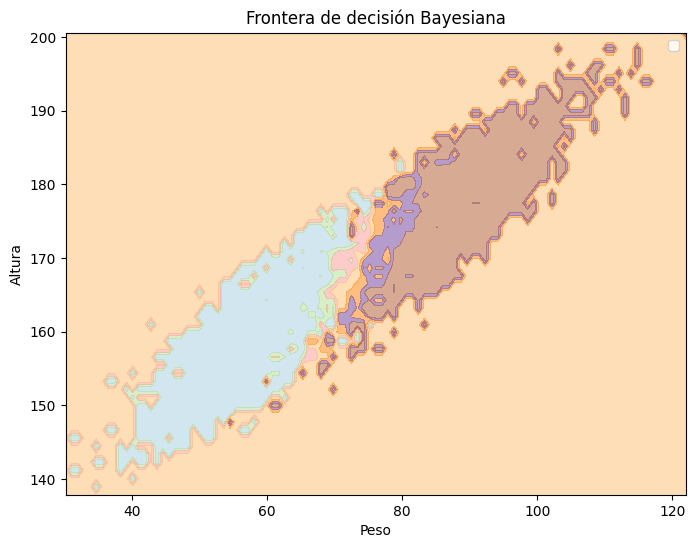

In [263]:

# Obtener las predicciones para la malla
Z_a = clasificar_malla_A(xx, yy)

# Graficar la frontera de decisión
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z_a, alpha=.5, cmap=plt.cm.Paired)
#plt.scatter(data_hombres_train[:, 0], data_hombres_train[:, 1], c='blue', label='Hombres')
#plt.scatter(data_mujeres_train[:, 0], data_mujeres_train[:, 1], c='red', label='Mujeres')
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.legend()
plt.title('Frontera de decisión Bayesiana')
plt.show()


Para la muestra  0 Se amplió  3 veces el espacio de comparación
Para la muestra  0 Se amplió  3 veces el espacio de comparación
Para la muestra  0 Se amplió  3 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  1 veces el espacio de comparación
Para la muestra  0 Se amplió  1 veces el espacio de comparación
Para la muestra  0 Se amplió  1 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  2 veces el espacio de comparación
Para la muestra  0 Se amplió  3 veces el

C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_22172\1719077019.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


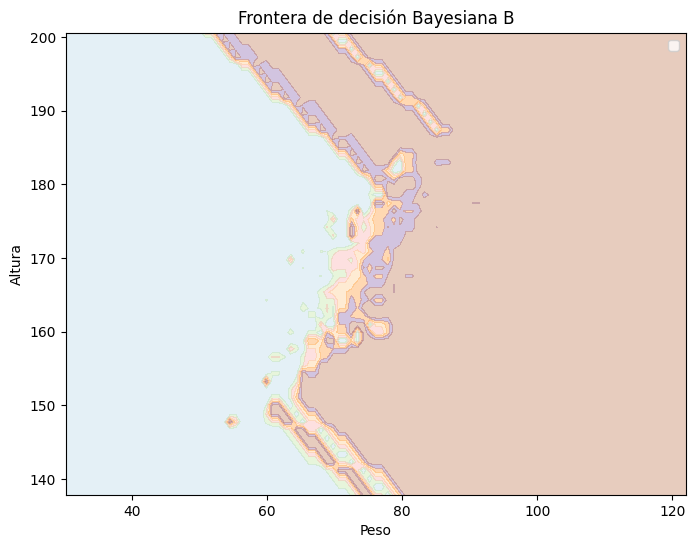

In [253]:
Z_b = clasificar_malla_B(xx, yy)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z_b, alpha=0.3, cmap=plt.cm.Paired)
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.legend()
plt.title('Frontera de decisión Bayesiana B')
plt.show()


C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_22172\1665448412.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


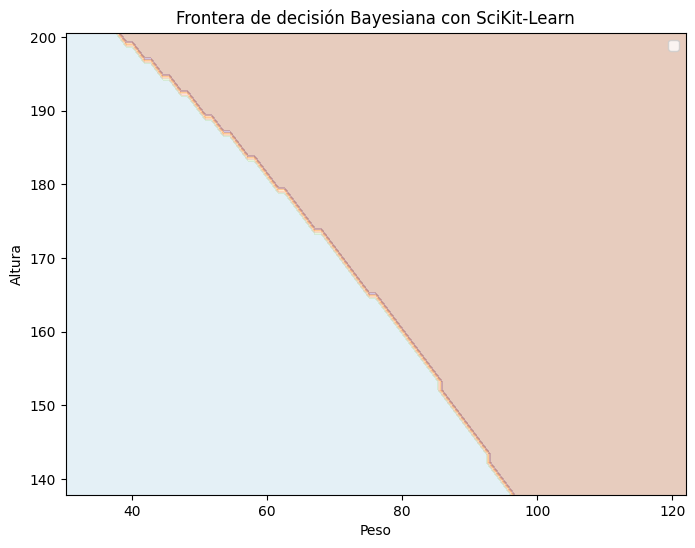

In [219]:
Z_sklearn = clasificar_malla_sklearn(xx, yy)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z_sklearn, alpha=0.3, cmap=plt.cm.Paired)
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.legend()
plt.title('Frontera de decisión Bayesiana con SciKit-Learn')
plt.show()

C:\Users\Juan Bautista\AppData\Local\Temp\ipykernel_22172\71053724.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


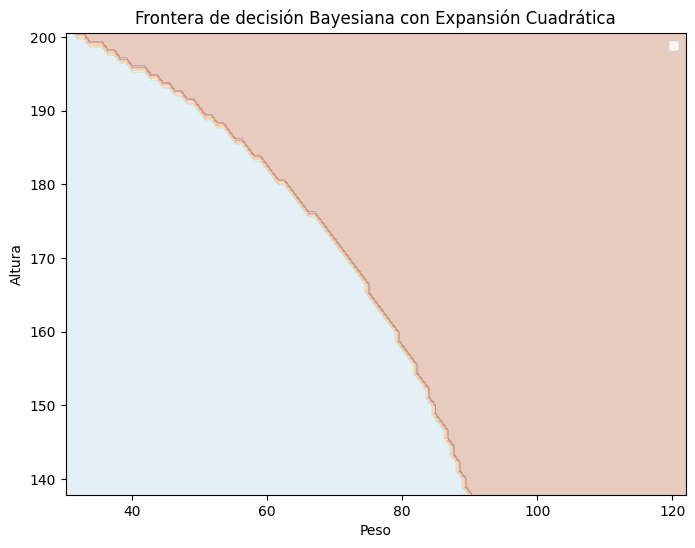

In [268]:
Z_expansion = clasificar_malla_expansion(xx, yy)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z_expansion, alpha=0.3, cmap=plt.cm.Paired)
plt.xlabel('Peso')
plt.ylabel('Altura')
plt.legend()
plt.title('Frontera de decisión Bayesiana con Expansión Cuadrática')
plt.show()

#

In [ ]:
log_Reg.score(wh_train, genero_train)
log_Reg.score(wh_test, genero_test)

0.916625

In [ ]:
log_Reg.predict_proba(wh_test)

array([[0.99667124, 0.00332876],
       [0.01263719, 0.98736281],
       [0.05574975, 0.94425025],
       ...,
       [0.00175142, 0.99824858],
       [0.96835524, 0.03164476],
       [0.01644652, 0.98355348]], shape=(2000, 2))

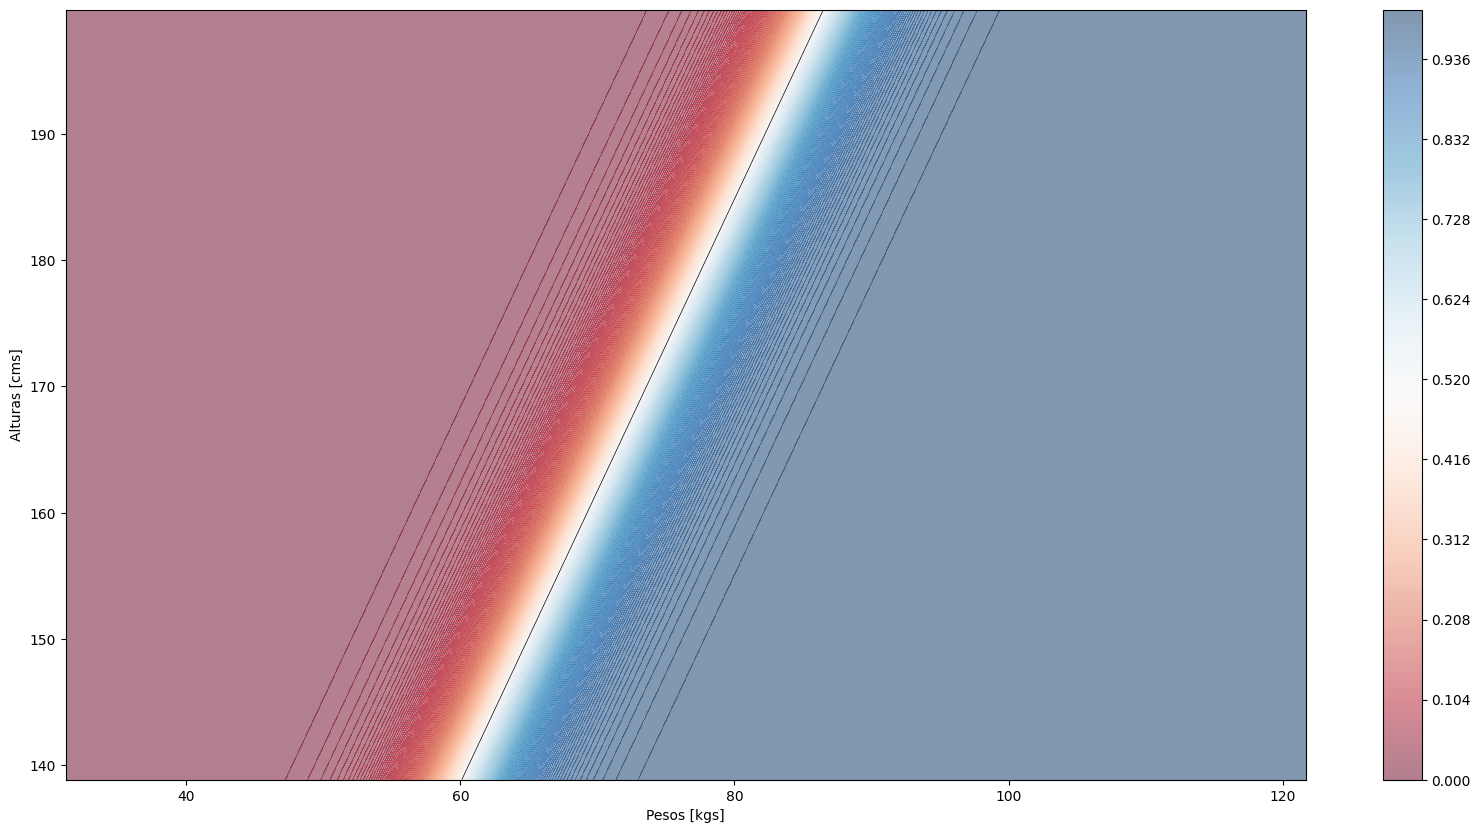

In [286]:
N = 300
X = np.linspace(data_train.min()['Peso'], data_train.max()['Peso'], N)
Y = np.linspace(data_train.min()['Altura'], data_train.max()['Altura'], N)
X, Y = np.meshgrid(X, Y)

Z_lr = log_Reg.predict_proba(np.c_[X.ravel(), Y.ravel()])[:, 0]

# Put the result into a color plot
Z_lr = Z_lr.reshape(X.shape)

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_lr, 256, alpha=.5, vmin=0., vmax=1., cmap=cm)
ax.contour(X, Y, Z_lr, (0.5,), colors='k', linewidths=0.5)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.colorbar(cf, ax=ax)
plt.show()